In [36]:
import sqlalchemy as sa
import pandas as pd

import json
import logging
import requests

from sqlalchemy import inspect
from sqlalchemy.sql import text

In [37]:
def get_database_engine(environment: str):
    if environment == 'production':
        url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
        params = requests.get(url).json()['params']
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
        )
    
    elif environment == 'staging':
        with open('alerceread_db_staging.json', 'r', encoding='utf-8') as f:
            params = json.load(f)
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        )
    else:
        raise ValueError(f'Environment "{environment}" not defined')
        
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    print('Available Tables:\n', tables)
    return engine

In [38]:
ENVIRONMENT = "production"
engine = get_database_engine(environment=ENVIRONMENT)
engine.begin()

Available Tables:
 ['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [39]:
from sqlalchemy import inspect

inspector = inspect(engine)
tables = inspector.get_table_names()
print(tables)

['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [40]:
inspector = inspect(engine)
columns = inspector.get_columns("object")

for column in columns:
    print(column["name"], column["type"])

oid VARCHAR
ndethist INTEGER
ncovhist INTEGER
mjdstarthist DOUBLE PRECISION
mjdendhist DOUBLE PRECISION
corrected BOOLEAN
stellar BOOLEAN
ndet INTEGER
g_r_max REAL
g_r_max_corr REAL
g_r_mean REAL
g_r_mean_corr REAL
meanra DOUBLE PRECISION
meandec DOUBLE PRECISION
sigmara DOUBLE PRECISION
sigmadec DOUBLE PRECISION
deltajd DOUBLE PRECISION
firstmjd DOUBLE PRECISION
lastmjd DOUBLE PRECISION
step_id_corr VARCHAR
diffpos BOOLEAN
reference_change BOOLEAN


In [41]:
from astropy.time import Time

min_last_mjd = Time("2025-03-19").mjd
min_first_mjd = Time("2023-10-19").mjd

print(min_last_mjd)

60753.0


In [42]:
ndet_min = 8

# Construimos la consulta SQL
query = f"""
    SELECT * FROM object 
    WHERE firstmjd >= {min_first_mjd} and lastmjd >= {min_last_mjd} and ndet >= {ndet_min};
"""

# Ejecutamos la consulta
objects = pd.read_sql_query(query, con=engine)

display(objects.head())
print(objects.shape)
print(objects.columns)

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,meanra,meandec,sigmara,sigmadec,deltajd,firstmjd,lastmjd,step_id_corr,diffpos,reference_change
0,ZTF24abmfqjf,234,2360,59735.411053,60754.524062,True,False,30,None,None,...,335.287682,43.551891,0.018236,0.013217,188.176134,60566.347928,60754.524062,27.5.0,True,False
1,ZTF25aadbeoy,326,1953,58455.263426,60753.144722,True,False,11,None,None,...,51.891138,41.525698,0.029064,0.021759,81.919815,60671.224907,60753.144722,27.5.0,True,False
2,ZTF24aaideuq,48,1119,59230.462396,60753.315035,True,False,15,None,None,...,173.765902,-20.639175,0.020696,0.019368,362.980104,60390.334931,60753.315035,27.5.0,True,False
3,ZTF24aaidwqi,43,1718,59165.507986,60754.288982,True,False,15,None,None,...,142.958668,23.809410,0.018874,0.017268,350.982720,60403.306262,60754.288982,27.5.0,True,False
4,ZTF25aadcxte,517,2794,58397.468576,60753.202975,True,False,29,None,None,...,91.718378,44.124056,0.017869,0.012827,81.966134,60671.236840,60753.202975,27.5.0,False,False


(2675, 22)
Index(['oid', 'ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist',
       'corrected', 'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'meanra', 'meandec', 'sigmara', 'sigmadec', 'deltajd',
       'firstmjd', 'lastmjd', 'step_id_corr', 'diffpos', 'reference_change'],
      dtype='object')


In [9]:
oids = list(objects.oid.values[:1])
#oids = ['ZTF24aafnfsk']
print(f'Num. oids: {len(oids)}')

oids = [f"'{oid}'" for oid in oids]
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
oids_mayor_8 = detections['oid'].value_counts()
oids = oids_mayor_8[oids_mayor_8 >= 8].index
print(f'Num. oids ndet >= 8: {len(oids)}')

oids = [f"'{oid}'" for oid in oids]
print(oids)

Num. oids: 1
Num. oids ndet >= 8: 1
["'ZTF24abmfqjf'"]


In [10]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
display(detections.head())
print(detections.shape)
print(detections.columns)

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF24abmfqjf,2812347926015015022,60566.347928,1,2812347926015,20.2349,1,2812,335.287695,43.551861,...,0.2111,NaN,16.852234,0.017958,0.022479,True,False,2.841198e+18,False,24.5.1
1,ZTF24abmfqjf,2812363966015015016,60566.363970,2,2812363966015,20.0705,1,2812,335.287703,43.551825,...,0.1525,NaN,15.869082,100.000000,0.009363,True,False,2.841198e+18,False,24.5.1
2,ZTF24abmfqjf,2829374166015015032,60583.374167,1,2829374166015,20.5396,1,2829,335.287677,43.551904,...,0.1547,NaN,16.837038,0.006106,0.014664,True,False,2.841198e+18,False,24.5.1
3,ZTF24abmfqjf,2840237856015015024,60594.237859,1,2840237856015,19.9507,1,2840,335.287601,43.551915,...,0.2622,NaN,16.860825,0.011951,0.018126,True,False,2.841198e+18,False,24.5.1
4,ZTF24abmfqjf,2860368416015015009,60614.368414,1,2860368416015,19.8751,1,2860,335.287690,43.551951,...,0.3602,NaN,16.839190,0.012412,0.018235,True,False,2.889196e+18,False,24.5.1


(23, 30)
Index(['oid', 'candid', 'mjd', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'ra', 'dec', 'magpsf', 'sigmapsf', 'magap', 'sigmagap', 'distnr', 'rb',
       'rbversion', 'drb', 'drbversion', 'magapbig', 'sigmagapbig', 'rfid',
       'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'corrected',
       'dubious', 'parent_candid', 'has_stamp', 'step_id_corr'],
      dtype='object')


In [11]:
detections

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF24abmfqjf,2812347926015015022,60566.347928,1,2812347926015,20.234900,1,2812,335.287695,43.551861,...,0.2111,NaN,16.852234,0.017958,0.022479,True,False,2.841198e+18,False,24.5.1
1,ZTF24abmfqjf,2812363966015015016,60566.363970,2,2812363966015,20.070500,1,2812,335.287703,43.551825,...,0.1525,NaN,15.869082,100.000000,0.009363,True,False,2.841198e+18,False,24.5.1
2,ZTF24abmfqjf,2829374166015015032,60583.374167,1,2829374166015,20.539600,1,2829,335.287677,43.551904,...,0.1547,NaN,16.837038,0.006106,0.014664,True,False,2.841198e+18,False,24.5.1
3,ZTF24abmfqjf,2840237856015015024,60594.237859,1,2840237856015,19.950700,1,2840,335.287601,43.551915,...,0.2622,NaN,16.860825,0.011951,0.018126,True,False,2.841198e+18,False,24.5.1
4,ZTF24abmfqjf,2860368416015015009,60614.368414,1,2860368416015,19.875100,1,2860,335.287690,43.551951,...,0.3602,NaN,16.839190,0.012412,0.018235,True,False,2.889196e+18,False,24.5.1
5,ZTF24abmfqjf,2864331276015015016,60618.331273,2,2864331276015,19.593700,1,2864,335.287702,43.551961,...,0.1718,NaN,15.861523,0.001681,0.014068,True,False,2.889196e+18,False,24.5.1
6,ZTF24abmfqjf,2866197616015015018,60620.197616,1,2866197616015,19.661400,1,2866,335.287743,43.551898,...,0.4972,NaN,16.843420,0.016804,0.021499,True,False,2.889196e+18,False,24.5.1
7,ZTF24abmfqjf,2868096166015015012,60622.096169,1,2868096166015,20.079300,1,2868,335.287801,43.551918,...,0.2104,NaN,16.852600,0.006587,0.015044,True,False,2.889196e+18,False,24.5.1
8,ZTF24abmfqjf,2871200276015015019,60625.200278,1,2871200276015,19.939500,1,2871,335.287717,43.551888,...,0.5453,NaN,16.840809,0.015063,0.020147,True,False,2.889196e+18,False,24.5.1
9,ZTF24abmfqjf,2873198106015015024,60627.198102,1,2873198106015,19.546300,1,2873,335.287667,43.551909,...,0.5501,NaN,16.861017,0.015413,0.020575,True,False,2.889196e+18,False,24.5.1


In [ ]:
detections['rb']

In [12]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
display(forced_photometry.head())
print(forced_photometry.shape)
print(forced_photometry.columns)

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2889196306015,ZTF24abmfqjf,60643.196308,2,335.287539,43.551895,None,None,18.654953,0.061679,...,19.627399,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
1,2896175976015,ZTF24abmfqjf,60650.175972,1,335.287539,43.551895,None,None,19.028925,0.050350,...,20.280701,1,0,1.114842,335.287964,43.551975,16.965000,0.015,0.464,0.003
2,2896236946015,ZTF24abmfqjf,60650.236944,2,335.287539,43.551895,None,None,18.644606,0.046541,...,19.898800,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
3,2898097596015,ZTF24abmfqjf,60652.097593,1,335.287539,43.551895,None,None,19.287626,0.056850,...,20.417601,1,0,1.114842,335.287964,43.551975,16.965000,0.015,0.464,0.003
4,2898141876015,ZTF24abmfqjf,60652.141875,2,335.287539,43.551895,None,None,18.451437,0.036467,...,20.145700,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005


(30, 42)
Index(['pid', 'oid', 'mjd', 'fid', 'ra', 'dec', 'e_ra', 'e_dec', 'mag',
       'e_mag', 'mag_corr', 'e_mag_corr', 'e_mag_corr_ext', 'isdiffpos',
       'corrected', 'dubious', 'parent_candid', 'has_stamp', 'field', 'rcid',
       'rfid', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'magzpsci',
       'magzpsciunc', 'magzpscirms', 'clrcoeff', 'clrcounc', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'programid', 'procstatus',
       'distnr', 'ranr', 'decnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr'],
      dtype='object')


In [13]:
forced_photometry

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2889196306015,ZTF24abmfqjf,60643.196308,2,335.287539,43.551895,None,None,18.654953,0.061679,...,19.627399,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
1,2896175976015,ZTF24abmfqjf,60650.175972,1,335.287539,43.551895,None,None,19.028925,0.050350,...,20.280701,1,0,1.114842,335.287964,43.551975,16.965000,0.015,0.464,0.003
2,2896236946015,ZTF24abmfqjf,60650.236944,2,335.287539,43.551895,None,None,18.644606,0.046541,...,19.898800,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
3,2898097596015,ZTF24abmfqjf,60652.097593,1,335.287539,43.551895,None,None,19.287626,0.056850,...,20.417601,1,0,1.114842,335.287964,43.551975,16.965000,0.015,0.464,0.003
4,2898141876015,ZTF24abmfqjf,60652.141875,2,335.287539,43.551895,None,None,18.451437,0.036467,...,20.145700,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
5,2906166306015,ZTF24abmfqjf,60660.166308,2,335.287539,43.551895,None,None,18.651110,0.083264,...,19.308100,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
6,2911142396015,ZTF24abmfqjf,60665.142396,2,335.287539,43.551895,None,None,18.498423,0.036424,...,20.238001,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
7,2913161806015,ZTF24abmfqjf,60667.161806,2,335.287539,43.551895,None,None,18.565140,0.042973,...,19.938700,1,0,1.099969,335.287933,43.551975,15.938999,0.015,0.151,0.005
8,2840201126015,ZTF24abmfqjf,60594.201123,2,335.287189,43.551764,None,None,19.128744,0.062449,...,20.104300,1,0,2.115768,335.287933,43.551975,15.938999,0.015,0.151,0.005
9,2838222266015,ZTF24abmfqjf,60592.222268,1,335.287189,43.551764,None,None,19.891798,0.071504,...,20.818701,1,0,2.130272,335.287964,43.551975,16.965000,0.015,0.464,0.003


In [15]:
# GET FEATURES
query_features = f"""
                SELECT * FROM feature as f 
                WHERE f.oid in ({','.join(oids)}) and f.version = '27.5.0';
                """

features = pd.read_sql_query(query_features, con=engine)
features

,oid,name,value,fid,version
0,ZTF24abmfqjf,Amplitude,2.770233e-02,1,27.5.0
1,ZTF24abmfqjf,Amplitude,1.412821e-02,2,27.5.0
2,ZTF24abmfqjf,AndersonDarling,9.735076e-01,1,27.5.0
3,ZTF24abmfqjf,AndersonDarling,2.916160e-01,2,27.5.0
4,ZTF24abmfqjf,Autocor_length,1.000000e+00,1,27.5.0
...,...,...,...,...,...
204,ZTF24abmfqjf,ulens_u0,8.037359e-01,1,27.5.0
205,ZTF24abmfqjf,ulens_u0,4.578029e-07,2,27.5.0
206,ZTF24abmfqjf,W1-W2,-2.400017e-02,0,27.5.0
207,ZTF24abmfqjf,W2-W3,1.173000e+00,0,27.5.0


In [16]:
def features_from_db(features: pd.DataFrame):
    def normalize_name(x: str | int):
        if "_0" in x:
            return x[:-2].replace("/", "_")
        return x.replace("/", "_")

    def normalize_fid(x):
        if x == 0:
            return None
        if x == 1:
            return "g"
        if x == 2:
            return "r"
        if x == 12:
            return "g,r"

    # features['name'] = features['name'] + '_' + features['fid'].astype(str)
    if len(features) >= 1:
        features["name"] = features.apply(lambda x: normalize_name(x["name"]), axis=1)
        features["fid"] = features.apply(lambda x: normalize_fid(x["fid"]), axis=1)
        return features
    else:
        return None

In [17]:
#features = features_from_db(features)
#features

In [18]:
data_dict = {
    "detections": detections,
    "forced_photometry": forced_photometry,
    "features": features,
    "xmatch": None,
    "reference": None,
}

In [19]:
import numpy as np

mag_corr_column = "magpsf_corr"
e_mag_corr_ext_column = "sigmapsf_corr_ext"
diff_mag_column = "magpsf"
e_diff_mag_column = "sigmapsf"
mag_corr_column_fp = "mag_corr"
e_mag_corr_ext_column_fp = "e_mag_corr_ext"
diff_mag_column_fp = "mag"
e_diff_mag_column_fp = "e_mag"
w1_column = "w1mpro"
w2_column = "w2mpro"
w3_column = "w3mpro"
w4_column = "w4mpro"


detection_keys = [
    "oid",
    "candid",
    "pid",
    "ra",
    "dec",
    "mjd",
    mag_corr_column,
    e_mag_corr_ext_column,
    diff_mag_column,
    e_diff_mag_column,
    "fid",
    "isdiffpos",
]

forced_photometry_keys = [
    "oid",
    "candid",
    "pid",
    "ra",
    "dec",
    "mjd",
    mag_corr_column_fp,
    e_mag_corr_ext_column_fp,
    diff_mag_column_fp,
    e_diff_mag_column_fp,
    "fid",
    "isdiffpos",
]

def mag2flux(mag):
    return 10 ** (-(mag - 23.9) / 2.5)

def mag_err_2_flux_err(mag_err, mag):
    return np.log(10.0) * mag2flux(mag) / 2.5 * mag_err

def recover_mag_and_emag_with_signed_flux(df):
    df["isdiffpos"] = np.sign(df["fluxdiff_uJy"]).astype(int)
    df["mag"] = -2.5 * np.log10(np.abs(df["fluxdiff_uJy"])) + 23.9
    df["e_mag"] = df["fluxerrdiff_uJy"] / np.abs(df["fluxdiff_uJy"])
    df.loc[df["fluxdiff_uJy"] == 0, ["mag", "e_mag"]] = np.nan
    return df

def get_det_AO_to_InputDTO(lightcurve):
    detections = lightcurve.copy()
    detections = detections[detections.unit == "diff_flux"].rename(
        columns={
            "brightness": "fluxdiff_uJy",
            "e_brightness": "fluxerrdiff_uJy",
        }
    )
    detections = recover_mag_and_emag_with_signed_flux(detections)
    return detections

def preprocess_detections_from_db(detections: pd.DataFrame) -> pd.DataFrame:

    detections_ = detections.copy()
    detections_.fillna(value=np.nan, inplace=True)
    detections_["forced"] = False
    detections_["unit"] = "diff_flux"

    detections_.rename(
        columns={
            mag_corr_column: "mag_corr",
            e_mag_corr_ext_column: "e_mag_corr_ext", # sigmapsf_corr_ext
            diff_mag_column: "mag",
            e_diff_mag_column: "e_mag",
        },
        inplace=True,
    )

    detections_.rename(
        columns={"mag_corr": "brightness", "e_mag_corr_ext": "e_brightness"},
        inplace=True,
    )

    detections_["brightness"] = mag2flux(detections_["mag"]) * detections_["isdiffpos"]
    detections_["e_brightness"] = mag_err_2_flux_err(
        detections_["e_mag"], detections_["mag"]
    )
    return detections_

def preprocess_forced_photometry_from_db(
    forced_photometry: pd.DataFrame,
) -> pd.DataFrame:

    forced_photometry_ = forced_photometry.copy()
    forced_photometry_.fillna(value=np.nan, inplace=True)
    forced_photometry_["unit"] = "diff_flux"
    forced_photometry_.rename(
        columns={
            mag_corr_column_fp: "mag_corr",
            e_mag_corr_ext_column_fp: "e_mag_corr_ext",
            diff_mag_column_fp: "mag",
            e_diff_mag_column_fp: "e_mag",
        },
        inplace=True,
    )

    forced_photometry_.rename(
        columns={"mag_corr": "brightness", "e_mag_corr_ext": "e_brightness"},
        inplace=True,
    )

    forced_photometry_["brightness"] = (
        mag2flux(forced_photometry_["mag"]) * forced_photometry_["isdiffpos"]
    )
    forced_photometry_["e_brightness"] = mag_err_2_flux_err(
        forced_photometry_["e_mag"], forced_photometry_["mag"]
    )

    forced_photometry_["candid"] = forced_photometry_["oid"].astype(str) + forced_photometry_["pid"].astype(str) 

    return forced_photometry_

def preprocess_detections_and_forced_photometry_from_db(
    detections: pd.DataFrame, forced_photometry: pd.DataFrame
) -> pd.DataFrame:
    columns = ['oid', 'mjd']
    print(f'detections:\n{detections[columns]}') 
    print(f'forced_photometry:\n{forced_photometry[columns]}') 

    detections_and_forced_photometry = pd.concat(
        [
            preprocess_detections_from_db(detections),
            preprocess_forced_photometry_from_db(forced_photometry),
        ]
    )

    detections_and_forced_photometry = get_det_AO_to_InputDTO(detections_and_forced_photometry)
    print(f'1. detections_and_forced_photometry:\n{detections_and_forced_photometry[columns]}') 
    detections_and_forced_photometry.drop_duplicates(["candid", "oid"], inplace=True)
    print(f'2. detections_and_forced_photometry:\n{detections_and_forced_photometry[columns]}')
    detections_and_forced_photometry.sort_values(
        by=["mjd", "forced"], ascending=[True, False], inplace=True
    )
    print(f'3. detections_and_forced_photometry:\n{detections_and_forced_photometry[columns]}')
    detections_and_forced_photometry.set_index("oid", inplace=True)
    return detections_and_forced_photometry

In [20]:
def preprocess_features_from_db(features: pd.DataFrame) -> pd.DataFrame:
    """features come from db in column format"""
    def fid_map(v):
        if v == 1:
            return "_1"  #'g'
        if v == 2:
            return "_2"  #'r'
        if v == 0:
            return ""
        
        if v == 12:
            return "_12"

    def normalize_name(v):
        return str(v).replace("-", "_").replace('/', '_')

    features_ = features.copy()
    features_["fid_name"] = features_["fid"].apply(lambda x: fid_map(x))
    features_["name"] = features_["name"] + features_["fid_name"]
    features_["name"] = features_["name"].apply(lambda x: normalize_name(x))
    features_ = features_[["oid", "name", "value"]]
    features_ = features_.pivot_table(
        index="oid", columns="name", values="value", aggfunc="first", dropna=False
    )

    return features_

In [21]:
from alerce_classifiers.base.dto import InputDTO
from alerce_classifiers.base._types import *

def transform_dataframes_to_input_dto(data: dict) -> InputDTO:
    """get dataframes from detections and forced photometry"""

    detections_and_forced_photometry = (
        preprocess_detections_and_forced_photometry_from_db(
            data["detections"], data["forced_photometry"]
        )
    )

    features = preprocess_features_from_db(data["features"])
    """ format dataframe of features """

    return InputDTO(
        Detections(detections_and_forced_photometry),
        NonDetections(pd.DataFrame()),
        Features(pd.DataFrame(features)),
        Xmatch(pd.DataFrame()),
        Stamps(pd.DataFrame()),
    )

In [22]:
inspector = inspect(engine)
columns = inspector.get_columns("object")

for column in columns:
    print(column["name"], column["type"])

oid VARCHAR
ndethist INTEGER
ncovhist INTEGER
mjdstarthist DOUBLE PRECISION
mjdendhist DOUBLE PRECISION
corrected BOOLEAN
stellar BOOLEAN
ndet INTEGER
g_r_max REAL
g_r_max_corr REAL
g_r_mean REAL
g_r_mean_corr REAL
meanra DOUBLE PRECISION
meandec DOUBLE PRECISION
sigmara DOUBLE PRECISION
sigmadec DOUBLE PRECISION
deltajd DOUBLE PRECISION
firstmjd DOUBLE PRECISION
lastmjd DOUBLE PRECISION
step_id_corr VARCHAR
diffpos BOOLEAN
reference_change BOOLEAN


In [23]:
input_dto = transform_dataframes_to_input_dto(data_dict)
input_dto

detections:
             oid           mjd
0   ZTF24abmfqjf  60566.347928
1   ZTF24abmfqjf  60566.363970
2   ZTF24abmfqjf  60583.374167
3   ZTF24abmfqjf  60594.237859
4   ZTF24abmfqjf  60614.368414
5   ZTF24abmfqjf  60618.331273
6   ZTF24abmfqjf  60620.197616
7   ZTF24abmfqjf  60622.096169
8   ZTF24abmfqjf  60625.200278
9   ZTF24abmfqjf  60627.198102
10  ZTF24abmfqjf  60627.241065
11  ZTF24abmfqjf  60629.196157
12  ZTF24abmfqjf  60639.183125
13  ZTF24abmfqjf  60639.203021
14  ZTF24abmfqjf  60643.196308
15  ZTF24abmfqjf  60648.177928
16  ZTF24abmfqjf  60650.175972
17  ZTF24abmfqjf  60663.131921
18  ZTF24abmfqjf  60665.096227
19  ZTF24abmfqjf  60667.098901
20  ZTF24abmfqjf  60667.161806
21  ZTF24abmfqjf  60671.114282
22  ZTF24abmfqjf  60754.524062
forced_photometry:
             oid           mjd
0   ZTF24abmfqjf  60643.196308
1   ZTF24abmfqjf  60650.175972
2   ZTF24abmfqjf  60650.236944
3   ZTF24abmfqjf  60652.097593
4   ZTF24abmfqjf  60652.141875
5   ZTF24abmfqjf  60660.166308
6   ZTF2

/tmp/ipykernel_2758101/731076981.py:104: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  forced_photometry_.fillna(value=np.nan, inplace=True)


InputDTO(_detections=Detections(_value=                                 candid           mjd  fid            pid  \
oid                                                                         
ZTF24abmfqjf        2812347926015015022  60566.347928    1  2812347926015   
ZTF24abmfqjf        2812363966015015016  60566.363970    2  2812363966015   
ZTF24abmfqjf  ZTF24abmfqjf2815283926015  60569.283924    1  2815283926015   
ZTF24abmfqjf  ZTF24abmfqjf2821159916015  60575.159919    1  2821159916015   
ZTF24abmfqjf  ZTF24abmfqjf2821197916015  60575.197917    2  2821197916015   
ZTF24abmfqjf  ZTF24abmfqjf2821261496015  60575.261493    3  2821261496015   
ZTF24abmfqjf  ZTF24abmfqjf2822199946015  60576.199942    2  2822199946015   
ZTF24abmfqjf  ZTF24abmfqjf2822266166015  60576.266169    1  2822266166015   
ZTF24abmfqjf  ZTF24abmfqjf2822290086015  60576.290081    3  2822290086015   
ZTF24abmfqjf  ZTF24abmfqjf2823249176015  60577.249178    1  2823249176015   
ZTF24abmfqjf  ZTF24abmfqjf28232834660

In [24]:
input_dto.features

name,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF24abmfqjf,0.027702,0.014128,0.973508,0.291616,1.0,1.0,0.2,0.375,0.0,0.0,...,0.30842,1.0,16.844429,15.849293,83.268659,56.886376,0.373851,0.938684,0.803736,4.578029e-07


In [25]:
from alerce_classifiers.mbappe.mapper import MbappeMapper
from alerce_classifiers.mbappe.model import MbappeClassifier

MBAPPE_MODEL_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/model.ckpt"
MBAPPE_QUANTILES_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/quantiles"
MBAPPE_CONFIG_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/configs"

model = MbappeClassifier(
    model_path=MBAPPE_MODEL_PATH,
    quantiles_dir=MBAPPE_QUANTILES_PATH,
    config_dir=MBAPPE_CONFIG_PATH,
    mapper=MbappeMapper(),
)

predictions = model.predict(input_dto)
df_local_mbappe = predictions.probabilities
df_local_mbappe = df_local_mbappe.reset_index()
df_local_mbappe = df_local_mbappe.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_mbappe['ranking'] = df_local_mbappe.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_mbappe

/home/dmoreno/pipeline_v4_final/pipeline/alerce_classifiers/alerce_classifiers/mbappe/mapper.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, self.dict_info["md_cols"]] = quantiles["quantile_md"].transform(
/home/dmoreno/pipeline_v4_final/pipeline/alerce_classifiers/alerce_classifiers/mbappe/mapper.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, self.dict_info["feat_cols"]] = quantiles[


,oid,class_name,probability,ranking
0,ZTF24abmfqjf,CEP,8.143846e-03,4
1,ZTF24abmfqjf,AGN,3.462441e-06,17
2,ZTF24abmfqjf,LPV,3.075679e-03,5
3,ZTF24abmfqjf,SNIa,1.515908e-04,10
4,ZTF24abmfqjf,EB/EW,7.538488e-04,6
5,ZTF24abmfqjf,CV/Nova,1.905672e-04,8
6,ZTF24abmfqjf,EA,1.403753e-02,3
7,ZTF24abmfqjf,QSO,6.877299e-07,20
8,ZTF24abmfqjf,YSO,4.717919e-06,16
9,ZTF24abmfqjf,SNII,2.262477e-07,21


In [26]:
query_to_prod_atat = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
                    and classifier_version = '0.3.6';
        """
df_prod_mbappe = pd.read_sql_query(query_to_prod_atat, con=engine) #[df_local_mbappe.columns]
df_prod_mbappe

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,AGN,6.687948e-04,11
1,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,Blazar,4.514923e-03,9
2,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,CEP,7.823438e-03,7
3,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,CV/Nova,4.508957e-02,4
4,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,DSCT,5.911544e-03,8
5,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,EA,1.940731e-01,3
6,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,EB/EW,9.069005e-03,6
7,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,LPV,1.072489e-02,5
8,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,Microlensing,7.846645e-08,21
9,ZTF24abmfqjf,LC_classifier_ATAT_forced_phot(beta),0.3.6,Periodic-Other,5.610682e-04,12


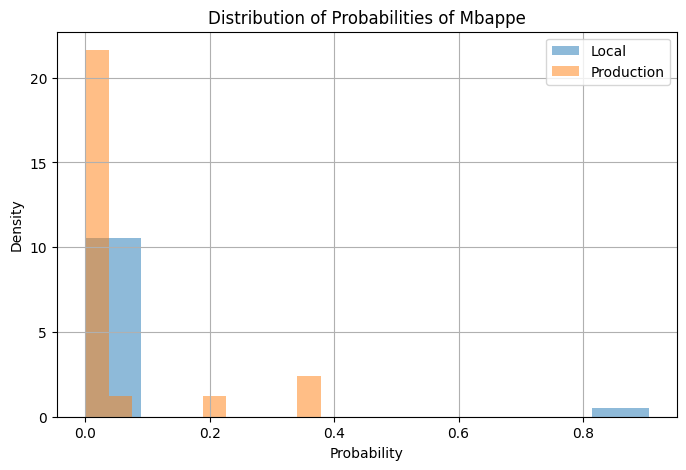

In [27]:
import matplotlib.pyplot as plt

# Crear el gráfico de distribución de probabilidades
plt.figure(figsize=(8, 5))
plt.hist(df_local_mbappe['probability'], bins=10, alpha=0.5, label='Local', density=True)
plt.hist(df_prod_mbappe['probability'], bins=10, alpha=0.5, label='Production', density=True)

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of Probabilities of Mbappe')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [28]:
df_mbappe = df_local_mbappe.merge(df_prod_mbappe, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_mbappe

,oid,class_name,probability_local,ranking_local,classifier_name,classifier_version,probability_prod,ranking_prod
0,ZTF24abmfqjf,CEP,8.143846e-03,4,LC_classifier_ATAT_forced_phot(beta),0.3.6,7.823438e-03,7
1,ZTF24abmfqjf,AGN,3.462441e-06,17,LC_classifier_ATAT_forced_phot(beta),0.3.6,6.687948e-04,11
2,ZTF24abmfqjf,LPV,3.075679e-03,5,LC_classifier_ATAT_forced_phot(beta),0.3.6,1.072489e-02,5
3,ZTF24abmfqjf,SNIa,1.515908e-04,10,LC_classifier_ATAT_forced_phot(beta),0.3.6,5.167070e-07,19
4,ZTF24abmfqjf,EB/EW,7.538488e-04,6,LC_classifier_ATAT_forced_phot(beta),0.3.6,9.069005e-03,6
5,ZTF24abmfqjf,CV/Nova,1.905672e-04,8,LC_classifier_ATAT_forced_phot(beta),0.3.6,4.508957e-02,4
6,ZTF24abmfqjf,EA,1.403753e-02,3,LC_classifier_ATAT_forced_phot(beta),0.3.6,1.940731e-01,3
7,ZTF24abmfqjf,QSO,6.877299e-07,20,LC_classifier_ATAT_forced_phot(beta),0.3.6,1.982288e-03,10
8,ZTF24abmfqjf,YSO,4.717919e-06,16,LC_classifier_ATAT_forced_phot(beta),0.3.6,3.408525e-01,2
9,ZTF24abmfqjf,SNII,2.262477e-07,21,LC_classifier_ATAT_forced_phot(beta),0.3.6,2.214706e-05,17


In [29]:
class_order = [
    "SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", 
    "TDE", "Microlensing", "QSO", "AGN", "Blazar", 
    "YSO", "CV/Nova", "LPV", "EA", "EB/EW", 
    "Periodic-Other", "RSCVn", "CEP", "RRLab", "RRLc", "DSCT"
]

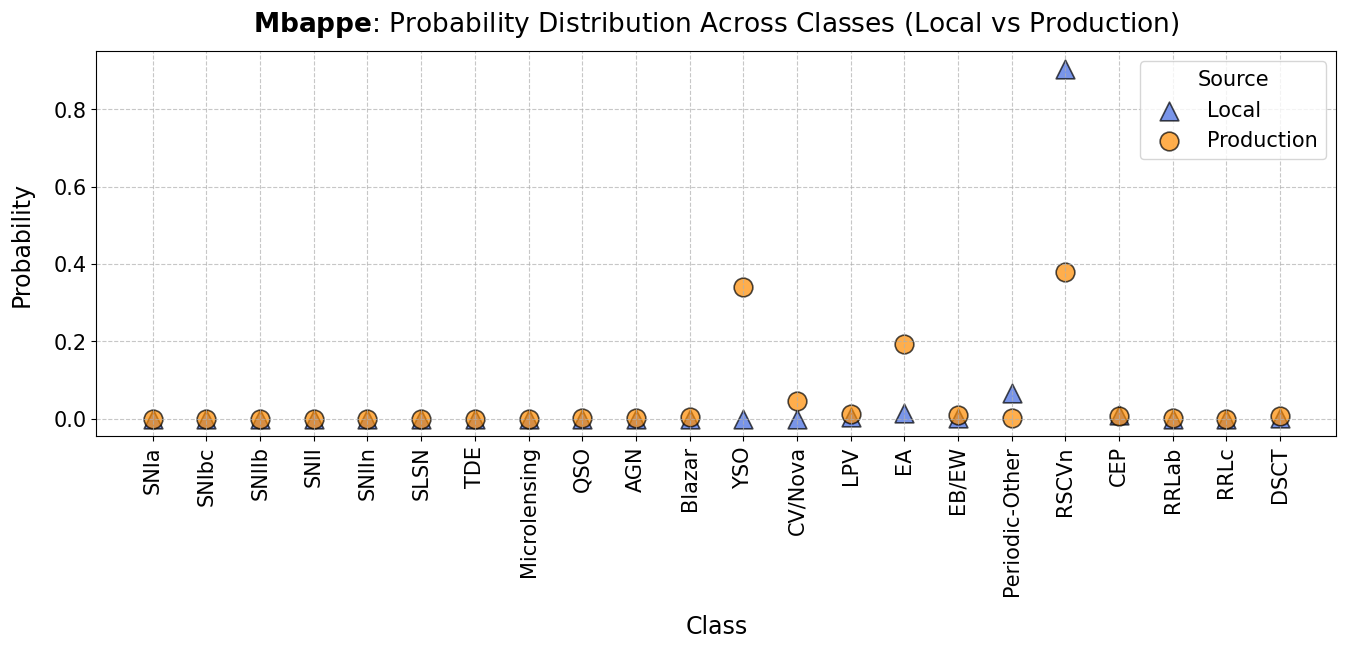

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir el orden deseado de las clases
class_order = [
    "SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", 
    "TDE", "Microlensing", "QSO", "AGN", "Blazar", 
    "YSO", "CV/Nova", "LPV", "EA", "EB/EW", 
    "Periodic-Other", "RSCVn", "CEP", "RRLab", "RRLc", "DSCT"
]

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

# Crear la figura y los ejes con estilo mejorado
fig, ax = plt.subplots(figsize=(16, 5))

# Asignar coordenadas numéricas basadas en el orden deseado
class_to_x = {cls: i for i, cls in enumerate(class_order)}
df_mbappe = df_mbappe[df_mbappe['class_name'].isin(class_order)]  # Filtrar solo las clases en class_order
df_mbappe['class_x'] = df_mbappe['class_name'].map(class_to_x)

# Local (triángulo azul)
ax.scatter(
    df_mbappe['class_x'],
    df_mbappe['probability_local'],
    color=color_local,
    marker="^",
    s=180,  # Tamaño más grande para mejor visualización
    label="Local",
    edgecolors="black",  # Borde para mejor contraste
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Producción (círculo naranja)
ax.scatter(
    df_mbappe['class_x'],
    df_mbappe['probability_prod'],
    color=color_prod,
    marker="o",
    s=180,
    label="Production",
    edgecolors="black",
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Personalizar etiquetas y diseño
ax.set_xticks(np.arange(len(class_order)))
ax.set_xticklabels(class_order, rotation=90, fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)

ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
title_text = r"$\bf{Mbappe}$: Probability Distribution Across Classes (Local vs Production)"
ax.set_title(title_text, fontsize=fs+4, pad=14, color='black')
ax.legend(fontsize=fs, loc='upper right', title="Source", title_fontsize=fs)
ax.grid(True, linestyle="--", alpha=0.7)

# Mostrar el gráfico con un estilo más limpio
plt.show()

In [31]:
from alerce_classifiers.squidward.model import (
    SquidwardFeaturesClassifier,
    SquidwardMapper,
)

SQUIDWARD_MODEL = "https://alerce-models.s3.amazonaws.com/squidward/1.1.5/hierarchical_random_forest_model.pkl"

model = SquidwardFeaturesClassifier(
    model_path=SQUIDWARD_MODEL,
    mapper=SquidwardMapper(),
)

predictions = model.predict(input_dto)
df_local_hbrf = predictions.probabilities
df_local_hbrf = df_local_hbrf.reset_index()
df_local_hbrf = df_local_hbrf.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_hbrf['ranking'] = df_local_hbrf.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_hbrf


,oid,class_name,probability,ranking
0,ZTF24abmfqjf,AGN,0.020782,12
1,ZTF24abmfqjf,Blazar,0.040555,7
2,ZTF24abmfqjf,CEP,0.029654,10
3,ZTF24abmfqjf,CV/Nova,0.044017,6
4,ZTF24abmfqjf,DSCT,0.031662,9
5,ZTF24abmfqjf,EA,0.068015,5
6,ZTF24abmfqjf,EB/EW,0.038157,8
7,ZTF24abmfqjf,LPV,0.015898,13
8,ZTF24abmfqjf,Microlensing,0.147459,3
9,ZTF24abmfqjf,Periodic-Other,0.154046,2


In [32]:
query_to_prod_hbrf = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_BHRF_forced_phot(beta)' 
                    and classifier_version = '1.1.5';
        """

df_prod_hbrf = pd.read_sql_query(query_to_prod_hbrf, con=engine) #[df_local_hbrf.columns]
df_prod_hbrf

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,AGN,0.023940,11
1,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,Blazar,0.041724,8
2,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,CEP,0.011440,18
3,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,CV/Nova,0.056772,6
4,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,DSCT,0.048048,7
5,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,EA,0.104104,4
6,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,EB/EW,0.026312,9
7,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,LPV,0.024024,10
8,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,Microlensing,0.108756,3
9,ZTF24abmfqjf,LC_classifier_BHRF_forced_phot(beta),1.1.5,Periodic-Other,0.116688,2


In [33]:
df_hbrf = df_local_hbrf.merge(df_prod_hbrf, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_hbrf

,oid,class_name,probability_local,ranking_local,classifier_name,classifier_version,probability_prod,ranking_prod
0,ZTF24abmfqjf,AGN,0.020782,12,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.023940,11
1,ZTF24abmfqjf,Blazar,0.040555,7,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.041724,8
2,ZTF24abmfqjf,CEP,0.029654,10,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.011440,18
3,ZTF24abmfqjf,CV/Nova,0.044017,6,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.056772,6
4,ZTF24abmfqjf,DSCT,0.031662,9,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.048048,7
5,ZTF24abmfqjf,EA,0.068015,5,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.104104,4
6,ZTF24abmfqjf,EB/EW,0.038157,8,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.026312,9
7,ZTF24abmfqjf,LPV,0.015898,13,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.024024,10
8,ZTF24abmfqjf,Microlensing,0.147459,3,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.108756,3
9,ZTF24abmfqjf,Periodic-Other,0.154046,2,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.116688,2


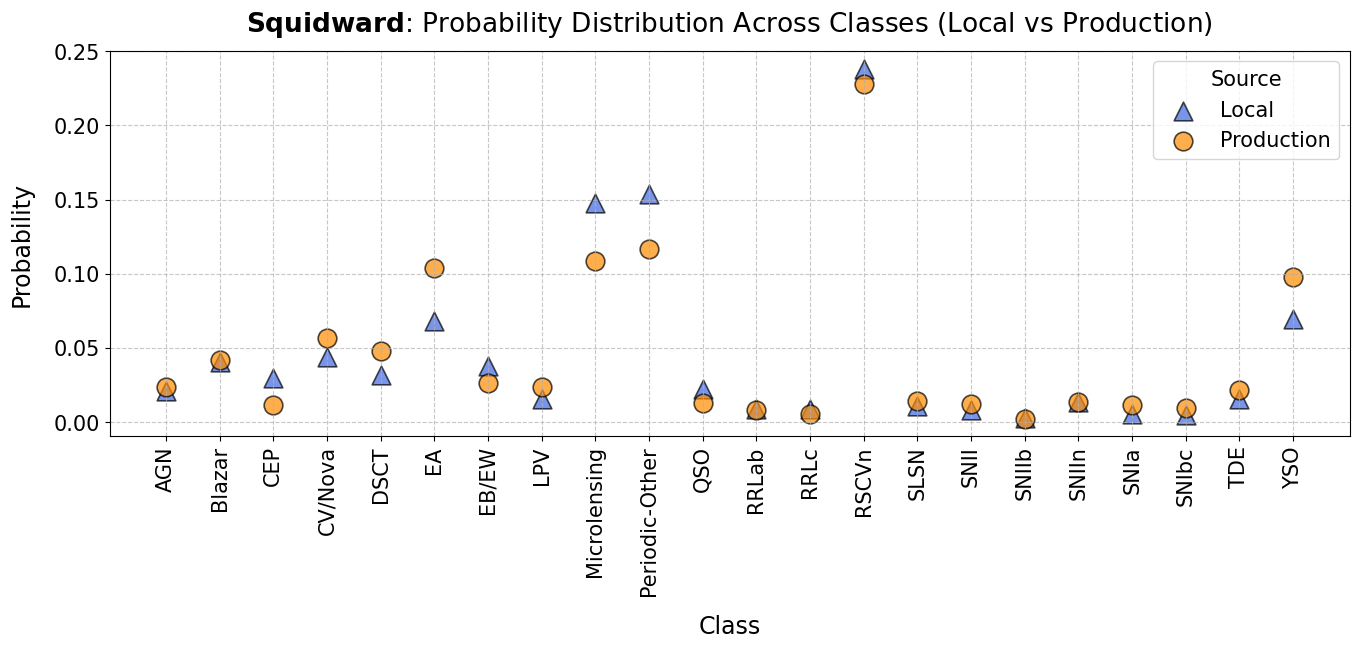

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

# Crear la figura y los ejes con estilo mejorado
fig, ax = plt.subplots(figsize=(16, 5))

# Convertir las clases en valores numéricos para la visualización
class_labels = df_hbrf['class_name'].unique()
class_to_x = {cls: i for i, cls in enumerate(class_labels)}
df_hbrf['class_x'] = df_hbrf['class_name'].map(class_to_x)

# Local (triángulo azul)
ax.scatter(
    df_hbrf['class_x'],
    df_hbrf['probability_local'],
    color=color_local,
    marker="^",
    s=180,  # Tamaño más grande para mejor visualización
    label="Local",
    edgecolors="black",  # Borde para mejor contraste
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Producción (círculo naranja)
ax.scatter(
    df_hbrf['class_x'],
    df_hbrf['probability_prod'],
    color=color_prod,
    marker="o",
    s=180,
    label="Production",
    edgecolors="black",
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Personalizar etiquetas y diseño
ax.set_xticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=90, fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)

ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
title_text = r"$\bf{Squidward}$: Probability Distribution Across Classes (Local vs Production)"
ax.set_title(title_text, fontsize=fs+4, pad=14, color='black')
ax.legend(fontsize=fs, loc='upper right', title="Source", title_fontsize=fs)
ax.grid(True, linestyle="--", alpha=0.7)

# Mostrar el gráfico con un estilo más limpio
plt.show()


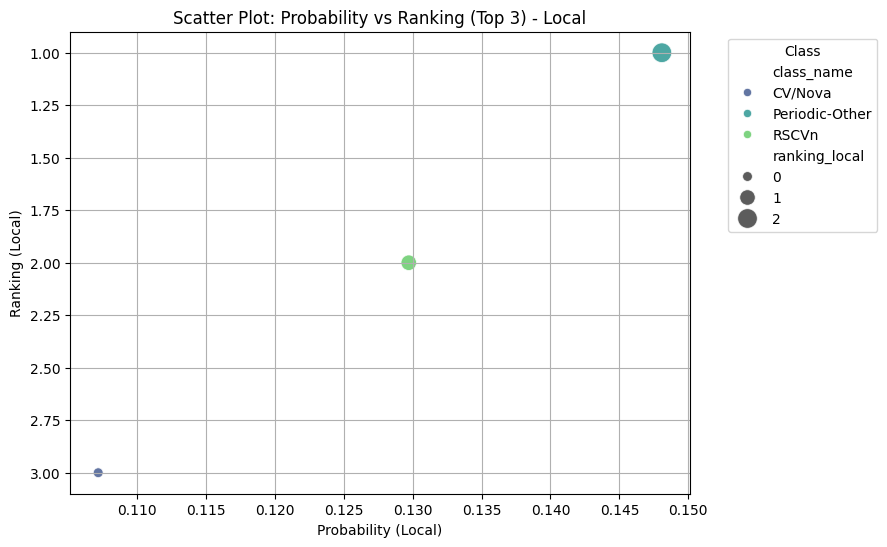

In [313]:
df_top3 = df_hbrf[(df_hbrf['ranking_local'] <= 3) | (df_hbrf['ranking_prod'] <= 3)]

# 1️⃣ Scatter Plot: Probabilidad vs Ranking (solo top 3)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_top3['probability_local'],
    y=df_top3['ranking_local'],
    hue=df_top3['class_name'],
    size=3 - df_top3['ranking_local'],  # Tamaño más grande para rank 1
    sizes=(50, 200),
    palette='viridis',
    alpha=0.8
)
plt.gca().invert_yaxis()  # Ranking 1 debe estar arriba
plt.xlabel('Probability (Local)')
plt.ylabel('Ranking (Local)')
plt.title('Scatter Plot: Probability vs Ranking (Top 3) - Local')
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

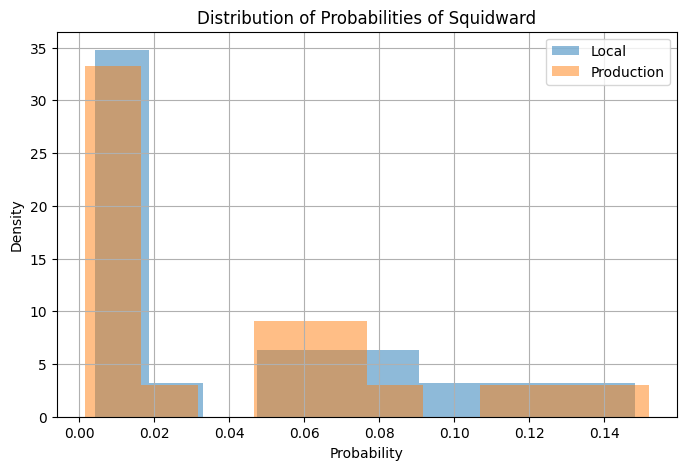

In [299]:
import matplotlib.pyplot as plt

# Crear el gráfico de distribución de probabilidades
plt.figure(figsize=(8, 5))
plt.hist(df_local_hbrf['probability'], bins=10, alpha=0.5, label='Local', density=True)
plt.hist(df_prod_hbrf['probability'], bins=10, alpha=0.5, label='Production', density=True)

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of Probabilities of Squidward')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

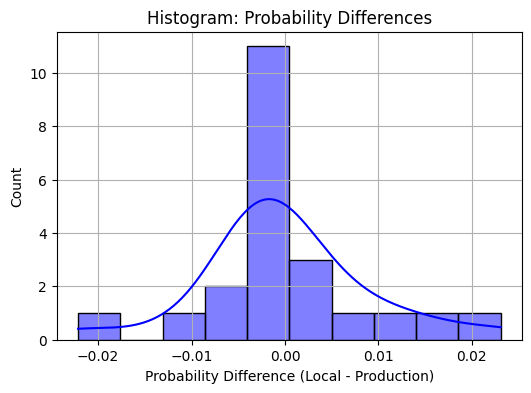

In [304]:
import seaborn as sns

# Calcular diferencia de probabilidades
df_hbrf['probability_diff'] = df_hbrf['probability_local'] - df_hbrf['probability_prod']

# 1️⃣ Histograma de Diferencias en Probabilidad
plt.figure(figsize=(6, 4))
sns.histplot(df_hbrf['probability_diff'], bins=10, kde=True, color='b')
plt.xlabel('Probability Difference (Local - Production)')
plt.ylabel('Count')
plt.title('Histogram: Probability Differences')
plt.grid(True)
plt.show()

/tmp/ipykernel_2365004/1155790633.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_hbrf['class_name'], y=df_hbrf['probability_diff'], palette='viridis')


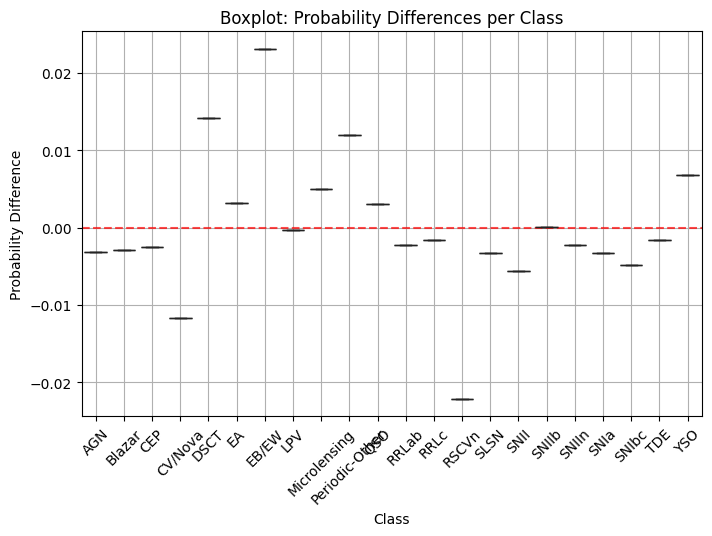

In [307]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_hbrf['class_name'], y=df_hbrf['probability_diff'], palette='viridis')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Probability Difference')
plt.title('Boxplot: Probability Differences per Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

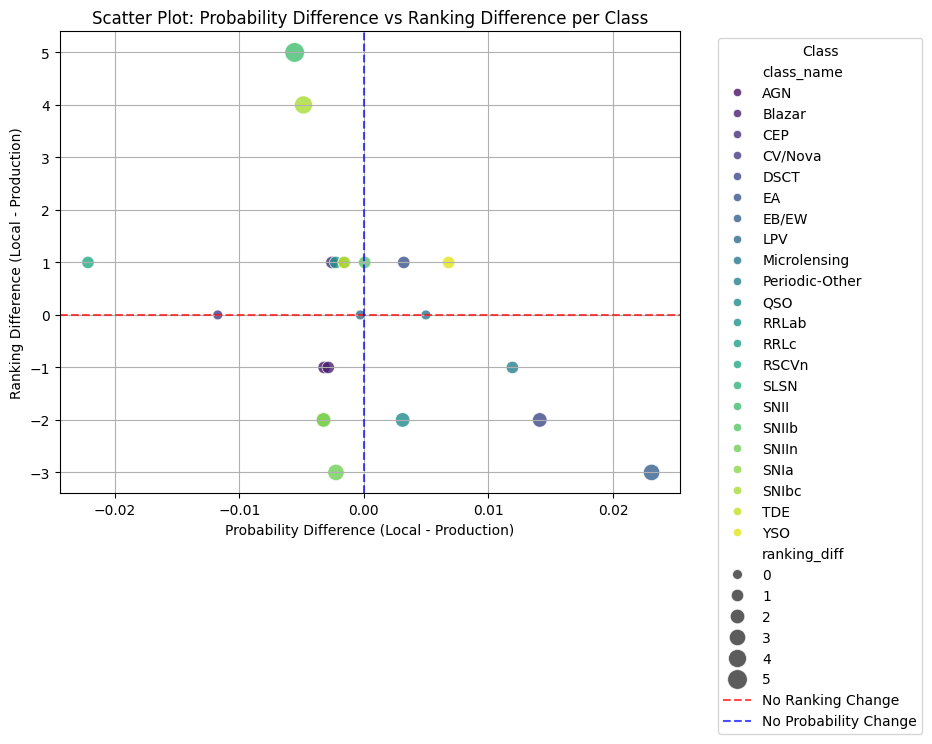

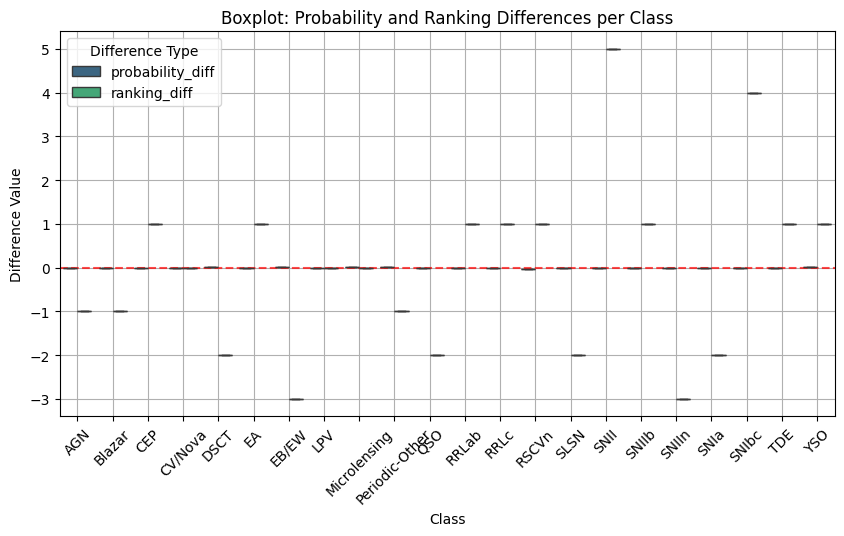

In [310]:
df_hbrf['ranking_diff'] = df_hbrf['ranking_local'] - df_hbrf['ranking_prod']
df_hbrf['probability_diff'] = df_hbrf['probability_local'] - df_hbrf['probability_prod']

# 1️⃣ Scatter Plot: Diferencia en Probabilidad vs Diferencia en Ranking por Clase
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_hbrf['probability_diff'],
    y=df_hbrf['ranking_diff'],
    hue=df_hbrf['class_name'],
    size=abs(df_hbrf['ranking_diff']),  # Tamaño según la magnitud del cambio en ranking
    sizes=(50, 200),
    palette='viridis',
    alpha=0.8
)
plt.axhline(0, linestyle='--', color='r', alpha=0.7, label='No Ranking Change')
plt.axvline(0, linestyle='--', color='b', alpha=0.7, label='No Probability Change')
plt.xlabel('Probability Difference (Local - Production)')
plt.ylabel('Ranking Difference (Local - Production)')
plt.title('Scatter Plot: Probability Difference vs Ranking Difference per Class')
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 2️⃣ Boxplot: Diferencia en Probabilidad y Ranking por Clase
plt.figure(figsize=(10, 5))
df_melted = df_hbrf.melt(id_vars=['class_name'], value_vars=['probability_diff', 'ranking_diff'], var_name='Difference Type', value_name='Value')
sns.boxplot(x='class_name', y='Value', hue='Difference Type', data=df_melted, palette='viridis')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Difference Value')
plt.title('Boxplot: Probability and Ranking Differences per Class')
plt.xticks(rotation=45)
plt.legend(title="Difference Type")
plt.grid(True)
plt.show()

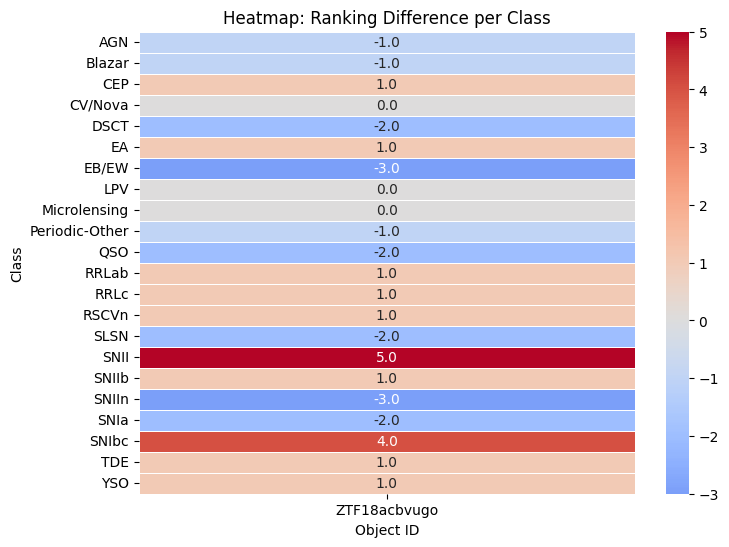

In [311]:
# 3️⃣ Heatmap de Cambio de Ranking por Clase
heatmap_data = pd.pivot_table(df_hbrf, values='ranking_diff', index='class_name', columns='oid', aggfunc='mean').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5, center=0)
plt.xlabel('Object ID')
plt.ylabel('Class')
plt.title('Heatmap: Ranking Difference per Class')
plt.show()

In [ ]:
from lc_classifier.utils import create_astro_object

ao = create_astro_object(
    data_origin='database',
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=None,
    reference=None,
    non_detections=None,
)

In [14]:
#oids = ["ZTF18aabgipf", "ZTF18aavtats"]
oids = ['ZTF20aclvqmx']
oids = [f"'{oid}'" for oid in oids]
#oids_str = ", ".join(f"'{oid}'" for oid in oids) 

In [15]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
detections

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF20aclvqmx,2716363714315015011,60470.363715,2,2716363714315,20.411406,1,2716,312.645362,11.953960,...,0.2394,5.431202e+08,18.124825,0.027930,0.031430,True,False,NaN,True,24.5.1
1,ZTF20aclvqmx,2718439834315015017,60472.439838,1,2718439834315,20.633200,1,2718,312.645267,11.953988,...,0.3947,NaN,19.084934,0.056601,0.058385,True,False,2.736391e+18,False,24.5.1
2,ZTF20aclvqmx,2722456904315015018,60476.456910,2,2722456904315,20.593800,1,2722,312.645356,11.954091,...,0.2158,NaN,18.108067,0.033905,0.036756,True,False,2.736391e+18,False,24.5.1
3,ZTF20aclvqmx,2725359274315015009,60479.359271,2,2725359274315,20.023352,1,2725,312.645291,11.954002,...,0.4066,5.431202e+08,18.116410,0.030457,0.033648,True,False,NaN,True,24.5.1
4,ZTF20aclvqmx,2736391454315015023,60490.391458,2,2736391454315,20.462019,1,2736,312.645366,11.954054,...,0.2747,5.431202e+08,18.122684,0.023093,0.027207,True,False,NaN,True,24.5.1
5,ZTF20aclvqmx,2740358994315015015,60494.358993,2,2740358994315,20.536700,1,2740,312.645397,11.954088,...,0.3566,NaN,18.141165,0.034247,0.037242,True,False,2.753358e+18,False,24.5.1
6,ZTF20aclvqmx,2753358264315015016,60507.358264,2,2753358264315,20.466166,1,2753,312.645331,11.954049,...,0.2636,5.431202e+08,18.113300,0.022522,0.026658,True,False,NaN,True,24.5.1
7,ZTF20aclvqmx,2784264004315025034,60538.264005,2,2784264004315,19.814900,1,2784,312.645415,11.954071,...,0.4117,NaN,18.080547,0.043095,0.045262,True,False,2.805232e+18,False,24.5.1
8,ZTF20aclvqmx,2795275934315015012,60549.275937,1,2795275934315,20.572600,1,2795,312.645396,11.954119,...,0.3597,NaN,19.037806,0.061131,0.062651,True,False,2.824193e+18,False,24.5.1
9,ZTF20aclvqmx,2803261404315015011,60557.261400,1,2803261404315,20.607700,1,2803,312.645469,11.954107,...,0.5656,NaN,19.028149,0.063716,0.065150,True,False,2.824193e+18,False,24.5.1


In [11]:
for col in detections.columns:
    print(col)

candid
oid
mjd
fid
pid
diffmaglim
isdiffpos
nid
ra
dec
magpsf
sigmapsf
magap
sigmagap
distnr
rb
rbversion
drb
drbversion
magapbig
sigmagapbig
rfid
magpsf_corr
sigmapsf_corr
sigmapsf_corr_ext
corrected
dubious
parent_candid
has_stamp
step_id_corr


In [12]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

# and procstatus in ('0', '57') ;
# Por que aplica el filtro procstatus entre 0 y 57?
forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
forced_photometry

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2973560900615,ZTF20aclvqmx,60727.560903,2,312.645314,11.954185,None,None,19.77495,0.519044,...,18.2817,1,0,0.304448,312.645294,11.954106,18.334,0.019,0.477,0.02


In [48]:
for col in forced_photometry.columns:
    print(col)

pid
oid
mjd
fid
ra
dec
e_ra
e_dec
mag
e_mag
mag_corr
e_mag_corr
e_mag_corr_ext
isdiffpos
corrected
dubious
parent_candid
has_stamp
field
rcid
rfid
sciinpseeing
scibckgnd
scisigpix
magzpsci
magzpsciunc
magzpscirms
clrcoeff
clrcounc
exptime
adpctdif1
adpctdif2
diffmaglim
programid
procstatus
distnr
ranr
decnr
magnr
sigmagnr
chinr
sharpnr


In [49]:
lc_det_ff = pd.concat([detections, forced_photometry])
lc_det_ff

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,adpctdif1,adpctdif2,programid,procstatus,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,ZTF20aclvqmx,2.716364e+18,60470.363715,2,2716363714315,20.411406,1,2716.0,312.645362,11.953960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF20aclvqmx,2.718440e+18,60472.439838,1,2718439834315,20.633200,1,2718.0,312.645267,11.953988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF20aclvqmx,2.722457e+18,60476.456910,2,2722456904315,20.593800,1,2722.0,312.645356,11.954091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZTF20aclvqmx,2.725359e+18,60479.359271,2,2725359274315,20.023352,1,2725.0,312.645291,11.954002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZTF20aclvqmx,2.736391e+18,60490.391458,2,2736391454315,20.462019,1,2736.0,312.645366,11.954054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ZTF20aclvqmx,NaN,60534.252222,1,2780252224315,20.719299,1,NaN,312.645416,11.954047,...,0.053127,0.052644,1.0,0,312.645264,11.954123,19.333000,0.018,0.587,-0.009
104,ZTF20aclvqmx,NaN,60532.323287,2,2778323284315,20.914801,1,NaN,312.645416,11.954047,...,0.052043,0.058391,1.0,0,312.645264,11.954128,18.303999,0.017,0.504,0.023
105,ZTF20aclvqmx,NaN,60532.253276,1,2778253274315,20.866301,1,NaN,312.645416,11.954047,...,0.054988,0.054125,1.0,0,312.645264,11.954123,19.333000,0.018,0.587,-0.009
106,ZTF20aclvqmx,NaN,60531.331169,1,2777331164315,20.761600,1,NaN,312.645416,11.954047,...,0.059938,0.061376,1.0,0,312.645264,11.954123,19.333000,0.018,0.587,-0.009


In [50]:
lc_det_ff_with_drop = lc_det_ff.drop_duplicates(
    ["candid", "oid"], keep="first"
)
lc_det_ff_with_drop

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,adpctdif1,adpctdif2,programid,procstatus,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,ZTF20aclvqmx,2.716364e+18,60470.363715,2,2716363714315,20.411406,1,2716.0,312.645362,11.953960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF20aclvqmx,2.718440e+18,60472.439838,1,2718439834315,20.633200,1,2718.0,312.645267,11.953988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF20aclvqmx,2.722457e+18,60476.456910,2,2722456904315,20.593800,1,2722.0,312.645356,11.954091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZTF20aclvqmx,2.725359e+18,60479.359271,2,2725359274315,20.023352,1,2725.0,312.645291,11.954002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZTF20aclvqmx,2.736391e+18,60490.391458,2,2736391454315,20.462019,1,2736.0,312.645366,11.954054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ZTF20aclvqmx,2.740359e+18,60494.358993,2,2740358994315,20.536700,1,2740.0,312.645397,11.954088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ZTF20aclvqmx,2.753358e+18,60507.358264,2,2753358264315,20.466166,1,2753.0,312.645331,11.954049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ZTF20aclvqmx,2.784264e+18,60538.264005,2,2784264004315,19.814900,1,2784.0,312.645415,11.954071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ZTF20aclvqmx,2.795276e+18,60549.275937,1,2795275934315,20.572600,1,2795.0,312.645396,11.954119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ZTF20aclvqmx,2.803261e+18,60557.261400,1,2803261404315,20.607700,1,2803.0,312.645469,11.954107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute Features

In [54]:
def patch_wise(oid_list):
    columns = ["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]
    df = pd.DataFrame({"oid": oid_list})  # Fill only the oid column
    for col in columns[1:]:  # Add empty columns for the rest
        df[col] = None
    return df

def features_from_db(features: pd.DataFrame):
    def normalize_name(x: str | int):
        if "_0" in x:
            return x[:-2].replace("/", "_")
        return x.replace("/", "_")

    def normalize_fid(x):
        if x == 0:
            return None
        if x == 1:
            return "g"
        if x == 2:
            return "r"
        if x == 12:
            return "g,r"

    # features['name'] = features['name'] + '_' + features['fid'].astype(str)
    if len(features) >= 1:
        features["name"] = features.apply(lambda x: normalize_name(x["name"]), axis=1)
        features["fid"] = features.apply(lambda x: normalize_fid(x["fid"]), axis=1)
        return features
    else:
        return None

In [1]:
# GET FEATURES
query_features = f"""
                    SELECT * FROM feature as f 
                    WHERE f.oid in ({','.join(oids)}) and f.version = '27.3.0';
                    """

features = pd.read_sql_query(query_features, con=engine)
features

NameError: name 'oids' is not defined

In [56]:
features = features_from_db(features)
features

,oid,name,value,fid,version
0,ZTF20aclvqmx,Amplitude,NaN,g,27.4.0
1,ZTF20aclvqmx,Amplitude,0.055532,r,27.4.0
2,ZTF20aclvqmx,AndersonDarling,NaN,g,27.4.0
3,ZTF20aclvqmx,AndersonDarling,0.999087,r,27.4.0
4,ZTF20aclvqmx,Autocor_length,NaN,g,27.4.0
...,...,...,...,...,...
204,ZTF20aclvqmx,ulens_u0,0.140078,g,27.4.0
205,ZTF20aclvqmx,ulens_u0,0.000853,r,27.4.0
206,ZTF20aclvqmx,W1-W2,NaN,None,27.4.0
207,ZTF20aclvqmx,W2-W3,NaN,None,27.4.0


In [58]:
from lc_classifier.utils import (
    #all_features_from_astro_objects,
    create_astro_object,
    #EmptyLightcurveException,
)

ImportError: Numba needs NumPy 1.26 or less

In [ ]:
ao = create_astro_object(
    data_origin='database',
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=None,
    reference=None,
    non_detections=None,
)

ao

In [ ]:
from lc_classifier.features.preprocess.ztf import (
    ZTFLightcurvePreprocessor,
)
from lc_classifier.features.composites.ztf import ZTFFeatureExtractor

lightcurve_preprocessor = ZTFLightcurvePreprocessor(drop_bogus=False)
lightcurve_preprocessor.preprocess_batch(batch_astro_objects)

In [ ]:
def dataframes_to_astro_object_list(
    detections,
    forced_photometry,
    xmatch,
    reference,
    features=None,
    data_origin="database",
    verbose=True,
):
    oids = detections["oid"].unique()
    detections.set_index("oid", inplace=True)
    detections.sort_index(inplace=True)
    forced_photometry_columns = forced_photometry.columns
    forced_photometry.set_index("oid", inplace=True)
    forced_photometry.sort_index(inplace=True)
    xmatch.set_index("oid", inplace=True)
    reference_columns = reference.columns
    reference.set_index("oid", inplace=True)
    astro_objects_list = []
    for oid in oids:
        try:
            xmatch_oid = xmatch.loc[[oid]].reset_index()
        except:
            logging.warning("xmatch metadata patched!")
            xmatch_oid = patch_xmatch_by_oid(oid=oid).reset_index()

        assert len(xmatch_oid) == 1
        xmatch_oid = xmatch_oid.iloc[0]
        if oid in forced_photometry.index:
            forced_photometry_oid = forced_photometry.loc[[oid]].reset_index()
        else:
            forced_photometry_oid = pd.DataFrame(columns=forced_photometry_columns)
        if oid in reference.index:
            reference_oid = reference.loc[[oid]].reset_index()
        else:
            reference_oid = pd.DataFrame(columns=reference_columns)
        try:
            ao = create_astro_object(
                data_origin=data_origin,
                detections=detections.loc[[oid]].reset_index(),
                forced_photometry=forced_photometry_oid,
                xmatch=xmatch_oid,
                reference=reference_oid,
                non_detections=None,
            )
            if features is not None:
                """add features from db"""
                try:
                    ao.features = features.loc[features.oid == oid][
                        ["name", "value", "fid", "version"]
                    ]
                except:
                    ao.features = None
        except EmptyLightcurveException:
            continue

        astro_objects_list.append(ao)
    return astro_objects_list

In [ ]:
engine = sa.create_engine(
    f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
)
engine.begin()


""" QUERIES """
# DETECTION
query_detections = f"""
                    SELECT * FROM detection
                    WHERE oid in ({oids_str}) and rb >= 0.55;
                    """
detections = pd.read_sql_query(query_detections, con=engine)

# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({oids_str}) and procstatus in ('0', '57');
                    """
forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)

# REFERENCE
query_reference = f"""
                    SELECT oid, rfid, sharpnr, chinr FROM reference
                    WHERE oid in ({oids_str}) and chinr >= 0;
                    """
reference = pd.read_sql_query(query_reference, con=engine)
reference = reference.drop_duplicates("rfid")

# XMATCH
query_xmatch = f"""
                SELECT oid, oid_catalog, dist FROM xmatch
                WHERE oid in ({oids_str}) and catid='allwise';
                """
xmatch = pd.read_sql_query(query_xmatch, con=engine)
xmatch = xmatch.sort_values("dist").drop_duplicates("oid")
oid_catalog = [f"'{oid}'" for oid in xmatch["oid_catalog"].values]

# ALL WISE
query_wise = f"""
            SELECT oid_catalog, w1mpro, w2mpro, w3mpro, w4mpro FROM allwise
            WHERE oid_catalog in ({','.join(oid_catalog)});
            """
try:
    wise = pd.read_sql_query(query_wise, con=engine).set_index("oid_catalog")
    wise = pd.merge(xmatch, wise, on="oid_catalog", how="outer")
    wise = wise[["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]].set_index("oid")
except:
    wise = patch_wise(oids)
    logging.warning("wise patched")

# PANSTARR
query_ps = f"""
            SELECT oid, sgscore1, sgmag1, srmag1, simag1, szmag1, distpsnr1 FROM ps1_ztf
            WHERE oid in ({oids_str});
            """
ps = pd.read_sql_query(query_ps, con=engine)
ps = ps.drop_duplicates("oid").set_index("oid")

#
xmatch = pd.concat([wise, ps], axis=1).reset_index()

# GET FEATURES
query_features = f"""
                    SELECT  * FROM feature as f 
                    WHERE f.oid  in ({oids_str}) and f.version = '27.3.0';
                    """
features = pd.read_sql_query(query_features, con=engine)
features = features_from_db(features)

# CREATE ASTRO OBJECTS FROM DATAFRAMES EXTRATED FROM DATABASE
output = dataframes_to_astro_object_list(
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=xmatch,
    reference=reference,
    features=features,
)

In [ ]:
from lc_classifier.features.preprocess.ztf import ZTFLightcurvePreprocessor
from lc_classifier.features.composites.ztf import ZTFFeatureExtractor
from lc_classifier.features.core.base import astro_object_from_dict

In [ ]:
lightcurve_preprocessor = ZTFLightcurvePreprocessor(drop_bogus=False)
lightcurve_preprocessor.preprocess_batch(batch_astro_objects)
feature_extractor = ZTFFeatureExtractor()
feature_extractor.compute_features_batch(batch_astro_objects, progress_bar=False)

In [17]:
# GET FEATURES
query_features = f"""
                    SELECT  * FROM feature as f 
                    WHERE f.oid  in ({oids_str}) and f.version = '27.4.0';
                    """

features = pd.read_sql_query(query_features, con=engine)
features

ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near "ZTF18aabgipf"
LINE 3:                     WHERE f.oid  in (''ZTF18aabgipf'', ''ZTF...
                                               ^

[SQL: 
                    SELECT  * FROM feature as f 
                    WHERE f.oid  in (''ZTF18aabgipf'', ''ZTF18aavtats'') and f.version = '27.4.0';
                    ]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [9]:
RANKING = 1

query_to_prod_bhrf = f"""
                SELECT  * FROM alerce.probability as p
                WHERE oid  in ({oids_str})
                        and p.classifier_name = 'LC_classifier_BHRF_forced_phot(beta)' 
                        and p.ranking = {RANKING} 
                        and classifier_version = '1.1.5';
            """

query_to_prod_atat = f"""
                SELECT  * FROM alerce.probability as p
                WHERE oid  in ({oids_str})
                        and p.classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
                        and p.ranking = {RANKING} 
                        and classifier_version = '0.3.6';
            """

engine = sa.create_engine('postgresql+psycopg2://' + params['user'] \
                          + ':' + params['password'] + '@' + params['host'] \
                          + '/' + params['dbname'])
engine.begin()

prod_probs_df_bhrf = pd.read_sql_query(query_to_prod_bhrf, con=engine)
prod_probs_df_atat = pd.read_sql_query(query_to_prod_atat, con=engine)

In [10]:
prod_probs_df_atat

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18aabgipf,LC_classifier_ATAT_forced_phot(beta),0.3.6,LPV,0.893018,1


In [11]:
prod_probs_df_bhrf

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18aabgipf,LC_classifier_BHRF_forced_phot(beta),1.1.5,LPV,0.689308,1


In [ ]:
a = ['ZTF17aaaafww',
 'ZTF17aaaagbs',
 'ZTF17aaaagvz',
 'ZTF17aaaagwz',
 'ZTF17aaaaotk',
 'ZTF17aaabate',
 'ZTF17aaabdxt',
 'ZTF17aaabebp',
 'ZTF17aaabebt',
 'ZTF17aaabwrg',
 'ZTF17aaacnht',
 'ZTF17aaaewdz',
 'ZTF17aaagezb',
 'ZTF17aaagtow',
 'ZTF17aaagypl',
 'ZTF17aaahegx',
 'ZTF17aaahejg',
 'ZTF17aaahere',
 'ZTF17aaahixx',
 'ZTF17aaahtvd',
 'ZTF17aaaiedz',
 'ZTF17aaaiegd',
 'ZTF17aaaignl',
 'ZTF17aaaihls',
 'ZTF17aaaihlz']


# Esos no dan iguales
b = ['ZTF17aaaewpk',
 'ZTF17aabrocy',
 'ZTF18aaaatqy',
 'ZTF18aaabter',
 'ZTF18aaakkxx',
 'ZTF18ablmuyz',
 'ZTF18absceqp',
 'ZTF18abzrmcq']
 

In [5]:
environment_variables = {
    "POSTGRES_USER": "postgres",
    "POSTGRES_PASSWORD": "postgres",
    "POSTGRES_DB": "ztf",
    "POSTGRES_PORT": 5432,
    "POSTGRES_HOST": "localhost",
    "POSTGRES_SCHEMA": "alerce",
    "N_JOBS": 16,
    "CONTAINER_NAME": "psql_docker",
    "CONTAINER_VOLUME_NAME": "integration_psql_data",
    "ASTRO_OBJECTS_PATH": "./batch/data",
    "ASTRO_OBJECTS_PATH_OUTPUT": "./batch/output",
}

In [15]:
import psycopg2

In [20]:
environment_variables = {
    "USER":"alerce",
    "PASSWORD":"IG,eFKHi5[",
    "HOST":"30.0.85.190",
    "PORT":"5432",
    "DB_NAME":"ztf"
    }

In [18]:
conn = psycopg2.connect(
    host=environment_variables['HOST'],
    port=environment_variables['PORT'],
    user=environment_variables['USER'],
    password=environment_variables['PASSWORD'],
    database=environment_variables['DB_NAME']
)

#lightcurves = pd.read_sql(query, conn)

OperationalError: connection to server at "30.0.85.190", port 5432 failed: Connection timed out
	Is the server running on that host and accepting TCP/IP connections?


In [ ]:
# Lista de OIDs y ranking
oids = ['ZTF17aaaiedz'] #, 'oid2', 'oid3']  # Reemplaza con tus OIDs
RANKING = 1  # Ajusta según sea necesario

# Consulta segura con parámetros
query = """
    SELECT * FROM alerce.probability
    WHERE oid IN %(oids)s
    AND classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
    AND ranking = %(ranking)s
    AND classifier_version = '0.3.4';
"""

# Ejecutar la consulta con parámetros
local_probs_df_atat = pd.read_sql(query, conn, params={'oids': tuple(oids), 'ranking': RANKING})

# Cerrar la conexión
conn.close()

In [ ]:
local_engine = sa.create_engine(
    f"postgresql+psycopg2://{environment_variables['POSTGRES_USER']}:{environment_variables['POSTGRES_PASSWORD']}@{environment_variables['POSTGRES_HOST']}/{environment_variables['POSTGRES_DB']}"
)

# Definir valores de detección
ndet_max = 50
ndet_min = 8

In [13]:
## Consulta SQL con parámetros seguros
#query = """
#    SELECT * FROM alerce.probability
#    WHERE classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
#    AND ranking <= 3 
#    AND ndet BETWEEN %(ndet_min)s AND %(ndet_max)s
#"""

## Ejecutar la consulta con parámetros
#local_probs_df_atat = pd.read_sql(query, conn, params={'ndet_min': ndet_min, 'ndet_max': ndet_max})


OperationalError: (psycopg2.OperationalError) connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
ndet_max = 50
ndet_min = 8

query_to_local_atat = f"""
                SELECT * from alerce.probability as p
                        WHERE p.classifier_name  = 'LC_classifier_ATAT_forced_phot(beta)' 
                            and p.ranking <=3 and ndet <= {ndet_max} and ndet >= {ndet_min} 
                """

#local_probs_df_bhrf = pd.read_sql_query(query_to_local_bhrf, con=local_engine)
local_probs_df_atat = pd.read_sql_query(query_to_local_atat, con=local_engine)